In [3]:
import pandas as pd
data=pd.read_csv(r'C:\Users\nguye\Downloads\sentiment-analysis-svm-distilbert\imdb_dataset.csv')
data.head()

,text,label,type
0,Story of a man who has unnatural feelings for ...,0,train
1,Airport '77 starts as a brand new luxury 747 p...,0,train
2,This film lacked something I couldn't put my f...,0,train
3,"Sorry everyone,,, I know this is supposed to b...",0,train
4,When I was little my parents took me along to ...,0,train


In [4]:
data.shape

(50000, 3)

In [5]:
# lọc ra 1 vài đòn
print(data[1:3])

                                                text  label   type
1  Airport '77 starts as a brand new luxury 747 p...      0  train
2  This film lacked something I couldn't put my f...      0  train


In [6]:
data['label'].value_counts()

label
0    25000
1    25000
Name: count, dtype: int64

xử lý cho model SVM

In [7]:
import re
import html
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# tải dữ liệu NLP cần thiết
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [8]:
def clean_text_svm(text):
    """
    Làm sạch text cho mô hình truyền thống như SVM, Logistic Regression.
    - Xóa HTML, ký tự đặc biệt, stopwords
    - Lemmatize để chuẩn hóa từ
    - Giữ lại chỉ các từ có ý nghĩa
    """
    # 1️ Giải mã ký tự HTML (ví dụ &amp; → &)
    text = html.unescape(text)

    # 2️ Loại bỏ thẻ HTML (<br />, <p>, ...)
    text = re.sub(r'<.*?>', ' ', text)

    # 3️ Đưa về chữ thường
    text = text.lower()

    # 4️ Chuẩn hóa Unicode (PokĂ©mon → Pokemon)
    text = unicodedata.normalize("NFKD", text).encode("ascii", "ignore").decode("utf-8", "ignore")

    # 5️ Bỏ ký tự không phải chữ cái
    text = re.sub(r'[^a-z\s]', ' ', text)

    # 6️ Thu gọn khoảng trắng
    text = re.sub(r'\s+', ' ', text).strip()

    # 7️ Tokenization
    tokens = word_tokenize(text)

    # 8️ Bỏ stopwords
    tokens = [w for w in tokens if w not in STOPWORDS]

    # 9️ Lemmatization
    tokens = [lemmatizer.lemmatize(w) for w in tokens]

    #  Ghép lại
    return " ".join(tokens)

In [9]:
svm_data = data['text'].apply(clean_text_svm)

In [11]:
print(svm_data.head(10))

0    story man unnatural feeling pig start opening ...
1    airport start brand new luxury plane loaded va...
2    film lacked something put finger first charism...
3    sorry everyone know supposed art film wow hand...
4    little parent took along theater see interior ...
5    appears many critic find idea woody allen dram...
6    second attempt new york intellectual less year...
7    know blame timid writer clueless director seem...
8    film mediocre best angie harmon funny bag hamm...
9    film bad way say story weak outdated especiall...
Name: text, dtype: object


In [12]:
print(svm_data[0])

story man unnatural feeling pig start opening scene terrific example absurd comedy formal orchestra audience turned insane violent mob crazy chanting singer unfortunately stay absurd whole time general narrative eventually making putting even era turned cryptic dialogue would make shakespeare seem easy third grader technical level better might think good cinematography future great vilmos zsigmond future star sally kirkland frederic forrest seen briefly


In [11]:
svm_df = pd.DataFrame({
    'text': svm_data,
    'label': data['label']
})

In [12]:
svm_df.head()

,text,label
0,story man unnatural feeling pig start opening ...,0
1,airport start brand new luxury plane loaded va...,0
2,film lacked something put finger first charism...,0
3,sorry everyone know supposed art film wow hand...,0
4,little parent took along theater see interior ...,0


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

fold = 1
for train_index, val_index in skf.split(svm_df['text'], svm_df['label']):
    print(f"\n===== Fold {fold} =====")

    X_train_text = svm_df['text'].iloc[train_index]
    X_val_text = svm_df['text'].iloc[val_index]
    y_train = svm_df['label'].iloc[train_index]
    y_val = svm_df['label'].iloc[val_index]

    # Fit TF-IDF chỉ trên train
    tfidf = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1,2),
        min_df=3,
        max_df=0.9
    )
    X_train = tfidf.fit_transform(X_train_text)
    X_val = tfidf.transform(X_val_text)

    # Huấn luyện mô hình
    model = LinearSVC(C=1.0,  max_iter=5000)

    model.fit(X_train, y_train)

    # Đánh giá
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)

    print(f"Độ chính xác: {acc:.4f}")
    print(classification_report(y_val, y_pred))

    fold += 1

print("\n==============================")
print(f"Độ chính xác trung bình 5 fold: {np.mean(accuracies):.4f}")
print("==============================")



===== Fold 1 =====
Độ chính xác: 0.8859
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      5000
           1       0.88      0.89      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000


===== Fold 2 =====
Độ chính xác: 0.8827
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      5000
           1       0.88      0.89      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000


===== Fold 3 =====
Độ chính xác: 0.8817
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      5000
           1       0.87      0.90      0.88      5000

    accuracy                           0.88     10000
   ma

In [14]:
import joblib

# Lưu lại mô hình và vectorizer
joblib.dump(model, "svm_model.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print(" Đã lưu mô hình và vectorizer thành công!")


 Đã lưu mô hình và vectorizer thành công!


In [ ]:
!pip install datasets -q
from datasets import load_dataset

# Load IMDb test set
imdb = load_dataset("imdb")
test_data = imdb["test"]

# Lấy ngẫu nhiên 50 mẫu để test
import random
sample_test = test_data.shuffle(seed=42).select(range(50))

texts = sample_test["text"]
true_labels = sample_test["label"]  # 0 = negative, 1 = positive

print("Sample size:", len(texts))
print(" Example:", texts[0][:200], "...")

📊 Sample size: 50
🔹 Example: <br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining King Lear story and of course Michelle Pfeiffer was in it, so what could go wrong?<br /><br />Very quic ...


In [ ]:
# 3️ Viết hàm test mô hình
def predict_sentiment_svm(text):
    clean = clean_text_svm(text)                     # làm sạch
    X = tfidf.transform([clean])                     # vector hóa
    pred = model.predict(X)[0]                    # dự đoán
    label = "Tích cực 😊" if pred == 1 else "Tiêu cực 😞"
    print(f"Câu: {text}\n→ Dự đoán: {label}\n")
    return pred
svm_preds = []
for text in texts:
    pred = predict_sentiment_svm(text)
    svm_preds.append(pred)


Câu: <br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining King Lear story and of course Michelle Pfeiffer was in it, so what could go wrong?<br /><br />Very quickly, however, I realized that this story was about A Thousand Other Things besides just Acres. I started crying and couldn't stop until long after the movie ended. Thank you Jane, Laura and Jocelyn, for bringing us such a wonderfully subtle and compassionate movie! Thank you cast, for being involved and portraying the characters with such depth and gentleness!<br /><br />I recognized the Angry sister; the Runaway sister and the sister in Denial. I recognized the Abusive Husband and why he was there and then the Father, oh oh the Father... all superbly played. I also recognized myself and this movie was an eye-opener, a relief, a chance to face my OWN truth and finally doing something about it. I truly hope A Thousand Acres has had the same effect on some others out there.<br /><br />S

🎯 Accuracy (SVM): 0.980

📋 Classification Report (SVM):
              precision    recall  f1-score   support

    Negative       1.00      0.96      0.98        28
    Positive       0.96      1.00      0.98        22

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50


🧩 Confusion Matrix:
[[27  1]
 [ 0 22]]


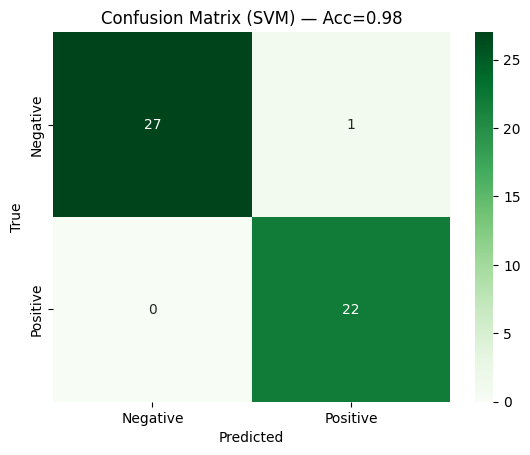

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# === Đánh giá mô hình SVM ===
acc_svm = accuracy_score(true_labels, svm_preds)
print(f"🎯 Accuracy (SVM): {acc_svm:.3f}\n")

print("📋 Classification Report (SVM):")
print(classification_report(true_labels, svm_preds, target_names=["Negative", "Positive"]))

cm = confusion_matrix(true_labels, svm_preds)
print("\n🧩 Confusion Matrix:")
print(cm)

# === Vẽ ma trận nhầm lẫn ===
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.title(f"Confusion Matrix (SVM) — Acc={acc_svm:.2f}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
